In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

C:\Users\JAEKYU\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def make_batch(train_data_path, label_data_path, batch_size):
    batch_size = batch_size
    data_length = len(train_data_path)
    index = np.arange(0, data_length)
    np.random.shuffle(index)
    batch_index = index[0:batch_size]
    shuffled_train_data = [train_data_path[i] for i in batch_index]
    shuffled_label_data = [label_data_path[i] for i in batch_index]

    return shuffled_train_data, shuffled_label_data

def cat_2000_path_load():
    train_data_folder_path = "./dataset/trainSet/trainSet/Stimuli/Social/x"
    train_label_folder_path = "./dataset/trainSet/trainSet/Stimuli/Social/label"
    test_data_folder_path = "./dataset/testSet/testSet/Stimuli/Social/x"
    test_label_folder_path = "./dataset/testSet/testSet/Stimuli/Social/label"
    
    train_data_path = os.listdir(train_data_folder_path)
    train_label_path = os.listdir(train_label_folder_path)
    test_data_path = os.listdir(test_data_folder_path)
    test_label_path = os.listdir(test_label_folder_path)
    
    length = len(train_data_path)
    tmp1 = []
    tmp2 = []
    tmp3 = []
    tmp4 = []
    for i in range(length):
        tmp1.append(train_data_folder_path + '/' + train_data_path[i])
        tmp2.append(test_data_folder_path + '/' + test_data_path[i])
        tmp3.append(train_label_folder_path + '/' + train_label_path[i])
        tmp4.append(test_label_folder_path + '/' + test_label_path[i])

    return tmp1, tmp2, tmp3, tmp4

def path_to_img(path, size):
    length = len(path)
    tmp = []
    for i in path:
        img_data = cv2.imread(i)
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        resized_img_data = cv2.resize(img_data, size)
        tmp.append(resized_img_data)
    return tmp

def data_normalize(data):
    numerator = data - np.min(data, 0)
    #denominator = 255
    denominator = np.max(data, 0) - np.min(data, 0)
    
    return (numerator / (denominator))

In [3]:
class Attention_Mechanism():
    def __init__(self, sess, batch_size):
        print("Attention_Mechinism init")
        self.sess = sess
        self.train_img_input = tf.placeholder(shape = [None, 299, 299, 3], dtype = tf.float32)
        self.train_label_input = tf.placeholder(shape = [None, 36, 36, 3], dtype = tf.float32)
        self.batch_size = batch_size
        self.model()
        self.optimizer()
    
    def model(self):
        #self.train_img_input -> batch, 299, 299, 3
        net = tf.layers.conv2d(inputs = self.train_img_input, filters = 32, kernel_size = [3, 3], strides = 2, padding = 'valid')
        net = tf.nn.relu(net)
        #net -> batch, 149, 149, 32
        print("first layer's shape : ", np.shape(net))
        
        net = tf.layers.conv2d(inputs = net, filters = 32, kernel_size = [3, 3], strides = 1, padding = 'valid')
        net = tf.nn.relu(net)
        #net -> batch, 147, 147, 32
        print("second layer's shape : ", np.shape(net))
        
        net = tf.layers.conv2d(inputs = net, filters = 64, kernel_size = [3, 3], strides = 1, padding = 'same')
        net = tf.nn.relu(net)
        #net -> batch, 147, 147, 64
        print("third layer's shape : ", np.shape(net))
        
        net = tf.layers.max_pooling2d(inputs = net, pool_size = [3, 3], strides = 2, padding = 'valid')
        net = tf.nn.relu(net)
        #net -> batch, 73, 73, 64
        print("fourth layer's shape : ", np.shape(net))
        
        net = tf.layers.conv2d(inputs = net, filters = 32, kernel_size = [3, 3], strides = 1, padding = 'same')
        net = tf.nn.relu(net)
        #net -> batch, 73, 73, 32
        print("fifth layer's shape : ", np.shape(net))
        
        net = tf.layers.conv2d(inputs = net, filters = 1, kernel_size = [3, 3], strides = 2, padding = 'valid')
        net = tf.nn.relu(net)
        #net -> batch, 36, 36, 1
        print("sixth layer's shape : ", np.shape(net))
        
        return net
    
    def optimizer(self):
        self.output = self.model()#batch, 36, 36, 1

        self.loss = tf.nn.l2_loss(self.output - self.train_label_input)
        self.loss_tmp = tf.reduce_mean([self.loss])
        
        self.optimizer_loss = tf.train.AdamOptimizer(learning_rate = 4e-03).minimize(self.loss_tmp)
        
        
    def train(self):
        data_size = 100
        total_batch = int(data_size / self.batch_size)
        #data load
        train_img_path, test_img_path, train_label_path, test_label_path = cat_2000_path_load()#this is just path.
        
    
        
        #saver
        SAVE_PATH = "C:/Users/JAEKYU/Documents/Jupyter Notebook/Attention_Mechanism/Weight/Weight.ckpt"
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        try:
            saver.restore(self.sess, SAVE_PATH)
            print("exist_weight load")
        except:
            print("weight no exist, make new weight.ckpt")
        
        loss_append = []
        for epoch in range(700):
            loss_sum = 0
            for i in range(total_batch):
                #make batch
                batch_train_img_path, batch_train_label_path = make_batch(train_img_path, train_label_path, self.batch_size)
                batch_train_img = path_to_img(batch_train_img_path, (299, 299))
                batch_train_label = path_to_img(batch_train_label_path, (36, 36))
                
                _, total_loss = self.sess.run([self.optimizer_loss, self.loss], feed_dict = {self.train_img_input : batch_train_img, self.train_label_input : batch_train_label})
                
                loss_append.append(total_loss)
                loss_sum = loss_sum + total_loss
                
            plt.imshow(batch_train_img[0])
            plt.show()
            
            result = self.sess.run([self.output], feed_dict = {self.train_img_input : batch_train_img})
            result = np.reshape(result, (self.batch_size, 36, 36))
            plt.imshow(result[0])
            plt.show()
            print("loss_sum : ", loss_sum)
            plt.plot(loss_append)
            plt.show()
            print(result)
            saver.save(self.sess, SAVE_PATH)
            
    def test(self):
        data_size = 100
        total_batch = int(data_size / self.batch_size)
        #data load
        train_img_path, test_img_path, train_label_path, test_label_path = cat_2000_path_load()
        batch_test_img_path, batch_test_label_path = make_batch(test_img_path, test_label_path, self.batch_size)
        batch_test_img = path_to_img(batch_test_img_path, (299, 299))
        batch_test_label = path_to_img(batch_test_label_path, (36, 36))
    
        
        #saver
        SAVE_PATH = "C:/Users/JAEKYU/Documents/Jupyter Notebook/Attention_Mechanism/Weight/Weight.ckpt"
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        try:
            saver.restore(self.sess, SAVE_PATH)
            print("exist_weight load")
        except:
            print("weight no exist, make new weight.ckpt")
        
        result = self.sess.run(self.output, feed_dict = {self.train_img_input : batch_test_img})
        result = np.reshape(result, [self.batch_size, 36, 36])
        
        
        
        
        output2 = np.zeros((16, 299, 299))
        output3 = np.zeros((16, 299, 299, 3))
        for i in range(16):
            output2[i] = cv2.resize(result[i], (299, 299))
        for i in range(16):
            for channel in range(3):
                output3[i, :, :, channel] = (output2[i, :, :] / 255.0)
        
        label2 = np.zeros((16, 299, 299, 3))
        for i in range(16):
            label2[i, :, :] = cv2.resize(batch_test_label[i], (299, 299))
        
        for i in range(16):
            for channel in range(3):
                label2[i, :, :, channel] = (label2[i, :, :, channel] / 255.0)        
        
        return batch_test_img, output3, label2
print("cell end")

cell end


In [ ]:
with tf.Session() as sess:
    obj = Attention_Mechanism(sess = sess, batch_size = 16)
    obj.train()

Attention_Mechinism init
first layer's shape :  (?, 149, 149, 32)
second layer's shape :  (?, 147, 147, 32)
third layer's shape :  (?, 147, 147, 64)
fourth layer's shape :  (?, 73, 73, 64)
fifth layer's shape :  (?, 73, 73, 32)
sixth layer's shape :  (?, 36, 36, 1)
first layer's shape :  (?, 149, 149, 32)
second layer's shape :  (?, 147, 147, 32)
third layer's shape :  (?, 147, 147, 64)
fourth layer's shape :  (?, 73, 73, 64)
fifth layer's shape :  (?, 73, 73, 32)
sixth layer's shape :  (?, 36, 36, 1)
INFO:tensorflow:Restoring parameters from C:/Users/JAEKYU/Documents/Jupyter Notebook/Attention_Mechanism/Weight/Weight.ckpt
exist_weight load


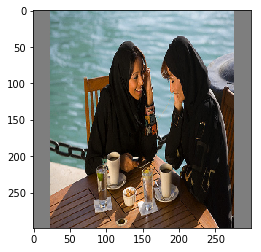

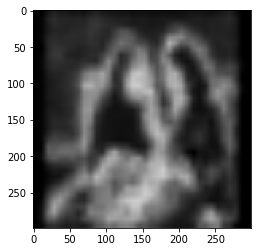

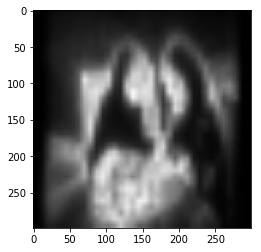

In [4]:
with tf.Session() as sess:
    obj = Attention_Mechanism(sess = sess, batch_size = 16)
    img, output, label = obj.test()

index = 0
plt.imshow(img[index])
plt.show()
plt.imshow(output[index])
plt.show()
plt.imshow(label[index])
plt.show()

In [5]:
np.shape(img)

(16, 299, 299, 3)

In [6]:
np.shape(output)

(16, 299, 299, 3)

In [7]:
np.shape(label)

(16, 299, 299, 3)

the label data and label output

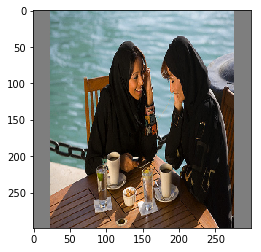

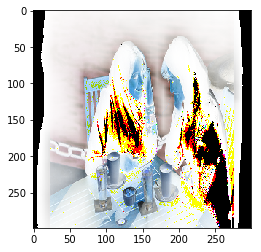

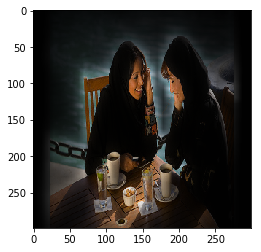

In [8]:
tmp = img * label
for i in range(16):
    for row in range(299):
        for col in range(299):
            for channel in range(3):
                tmp[i][row][col][channel] = int(tmp[i][row][col][channel])
plt.imshow(img[0])
plt.show()
plt.imshow(tmp[0])
plt.show()
for i in range(16):
    for row in range(299):
        for col in range(299):
            for channel in range(3):
                tmp[i][row][col][channel] = 255 - (tmp[i][row][col][channel])
plt.imshow(tmp[0])
plt.show()

network output and network output's attention visual

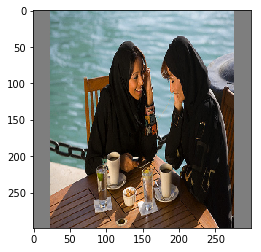

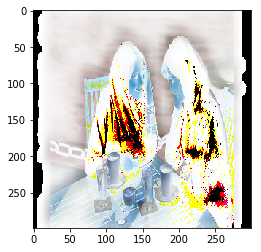

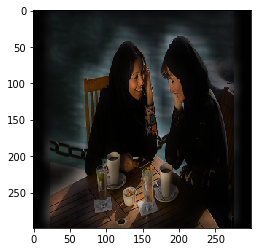

In [9]:
plt.imshow(img[0])
plt.show()
tmp = img * output
for i in range(16):
    for row in range(299):
        for col in range(299):
            for channel in range(3):
                tmp[i][row][col][channel] = int(tmp[i][row][col][channel])
plt.imshow(tmp[0])
plt.show()
for i in range(16):
    for row in range(299):
        for col in range(299):
            for channel in range(3):
                tmp[i][row][col][channel] = 255 - (tmp[i][row][col][channel])
plt.imshow(tmp[0])
plt.show()